In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.linear_model
import sklearn.neural_network
import matplotlib as mpl
import matplotlib.pyplot as plt
import colorsys
import json
import nncolor
import nncolor.data as nc

In [2]:
data = pd.read_csv('./resources/experiment_1_1_combined_edited.csv')
train_data, test_data, val_data = nc.split(data)

In [3]:
def to_hsv(d):
    res = pd.concat([pd.DataFrame([
        [row['ans'], *colorsys.rgb_to_hsv(row['circle_r'], row['circle_g'], row['circle_b']), 
         colorsys.rgb_to_hsv(*[row['bg_r'],]*3)[2]]],
        columns=['ans', 'circle hue', 'circle sat', 'circle val', 'bg val'])
     for idx, row in d.iterrows()])
    return res

data_hsv = to_hsv(data)
data_hsv.shape


(1517, 5)

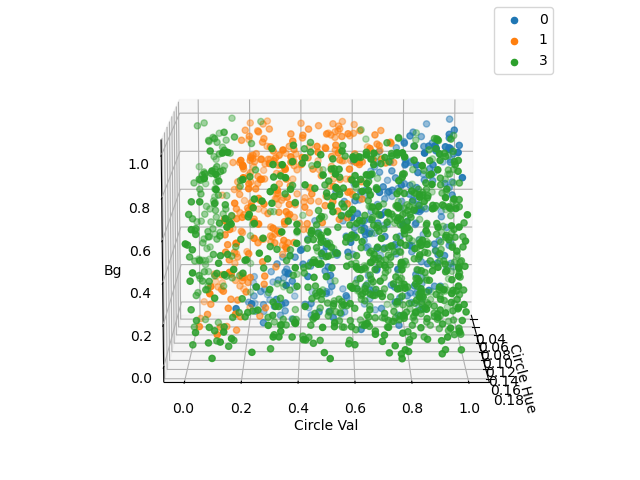

In [4]:
%matplotlib widget
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
for c in [0, 1, 3]:
    x = data_hsv.loc[data_hsv['ans'] == c, 'circle hue']
    y = data_hsv.loc[data_hsv['ans'] == c, 'circle val']
    z = data_hsv.loc[data_hsv['ans'] == c, 'bg val']
    ax.scatter(x,y,z, label=c)  # this way you can control color/marker/size of each group freely
    ax.set_xlabel('Circle Hue')
    ax.set_ylabel('Circle Val')
    ax.set_zlabel('Bg')
ax.legend()
ax.view_init(10, 0)

In [5]:
orange_or_brown = data_hsv[data_hsv['ans'].isin((0, 1))]
orange = data_hsv[data_hsv['ans'].isin((0, ))]
brown = data_hsv[data_hsv['ans'].isin((1,))]
both = data_hsv[data_hsv['ans'].isin((2,))]
neither = data_hsv[data_hsv['ans'].isin((3,))]
X = orange_or_brown[['circle hue', 'circle sat', 'circle val', 'bg val']].to_numpy()
y = orange_or_brown['ans']

def as_X(ptable):
    if 'circle hue' in ptable.columns:
        return ptable[['circle hue', 'circle sat', 'circle val', 'bg val']].to_numpy()
    else:
        return ptable[['circle_r', 'circle_g', 'circle_b', 'bg_r']].to_numpy()

def as_Xy(pdata, class_0, class_1):
    all_classes = class_0 +  class_1
    filtered = pdata[pdata['ans'].isin(all_classes)]
    X = as_X(filtered)
    y = filtered['ans']
    y = y.apply(lambda i : 0 if i in class_0 else 1)
    return X, y
#assert np.array_equal(X_test, X) and np.array_equal(y_test, y)

X_orange = as_X(orange)
X_brown = as_X(brown)
X_both = as_X(both)
X_neither = as_X(neither)

In [6]:
def print_min_max(ds):
    min_ = ds.min()
    max_ = ds.max()
    print('MIN')
    print(min_)
    print('MAX')
    print(max_)

print("Orange or brown")
print_min_max(orange_or_brown)
print("All")
print_min_max(data_hsv)

Orange or brown
MIN
ans           0.000000
circle hue    0.040021
circle sat    0.165457
circle val    0.019313
bg val        0.001038
dtype: float64
MAX
ans           1.000000
circle hue    0.163806
circle sat    0.997000
circle val    0.998380
bg val        0.993696
dtype: float64
All
MIN
ans           0.000000
circle hue    0.040021
circle sat    0.000679
circle val    0.000180
bg val        0.001038
dtype: float64
MAX
ans           3.000000
circle hue    0.176777
circle sat    0.999016
circle val    0.999300
bg val        0.998774
dtype: float64


Can raise the min circle saturation to about 0.15

In [7]:
model = sk.linear_model.LogisticRegression(
    solver='liblinear', class_weight='balanced')
model.fit(X, y)
v = model.coef_[0]
b = model.intercept_
print(f'v: {v}, b: {b}')
y_predict = model.predict(X)
accuracy = sk.metrics.accuracy_score(y, y_predict)
print(f'Accuracy: {accuracy}')

v: [ 0.92163431 -1.25406499 -8.15600133  5.35231535], b: [1.89147702]
Accuracy: 0.9725557461406518


In [19]:
X_orange @ v + b;

In [12]:
def classify2():
    X, y = as_Xy(data_hsv, class_0=(3,), class_1=(0,1,2))
    model = sk.linear_model.LogisticRegression(
        solver='liblinear',
        class_weight={0:1, 1: 10})
    model.fit(X, y)
    v = model.coef_[0]
    b = model.intercept_
    print(f'v: {v}, b: {b}')
    y_predict = model.predict(X)
    accuracy = sk.metrics.recall_score(y, y_predict)
    print(f'Recall: {accuracy}')
    print(f'Num exclude: {len(y_predict) - np.count_nonzero(y_predict)}') 
    print(f'Num include: {np.count_nonzero(y_predict)}') 
    exclude = data_hsv[data_hsv['circle sat'] < 0.05]
    print(np.count_nonzero(model.predict(as_X(exclude))))
classify2()

v: [-18.98851248   2.91729522  -1.44684852   1.58152362], b: [1.92274336]
Recall: 1.0
Num exclude: 161
Num include: 1356
10


In [14]:
def classify_circle_rgb_only():
    X, y = as_Xy(data, class_0=(0,), class_1=(1,))
    X = X[:,1:4]
    model = sk.linear_model.LogisticRegression(
        solver='liblinear',
        class_weight='balanced')
    model.fit(X, y)
    v = model.coef_[0]
    b = model.intercept_
    print(f'v: {v}, b: {b}')
    y_predict = model.predict(X)
    accuracy = sk.metrics.accuracy_score(y, y_predict)
    print(f'Accuracy: {accuracy}')
classify_circle_rgb_only()

def classify_bg_rgb_only():
    X, y = as_Xy(data, class_0=(0,), class_1=(1,))
    X = X[:, 3:4]
    model = sk.linear_model.LogisticRegression(
        solver='liblinear',
        class_weight='balanced')
    model.fit(X, y)
    v = model.coef_[0]
    b = model.intercept_
    print(f'v: {v}, b: {b}')
    y_predict = model.predict(X)
    accuracy = sk.metrics.accuracy_score(y, y_predict)
    print(f'Accuracy: {accuracy}')
classify_bg_rgb_only()

v: [-7.49972137  0.44580334  4.26445705], b: [0.09141476]
Accuracy: 0.8473413379073756
v: [2.56757375], b: [-1.36848644]
Accuracy: 0.6826758147512865


In [22]:
def print_vb(v, b):
    print(f'v: {v}, b: {b}')
    print(f'v_n: {v/np.linalg.norm(v)}, b_n: {b/np.linalg.norm(v)} [normalized]')
    
def mlp_model_binary():
    "Using all data"
    model = sk.linear_model.LogisticRegression(
        solver='liblinear',
        class_weight='balanced')
    def toXy(d):
        filtered = d[d['ans'].isin({0, 1})]
        X = filtered[['circle hue', 'circle sat', 'circle val', 'bg val']].to_numpy()
        y = filtered[['ans']].to_numpy().squeeze()
        return X, y
    X, y = toXy(data_hsv)
    model.fit(X, y)
    v = model.coef_[0]
    b = model.intercept_
    print_vb(v, b)
    Xtest, ytest = toXy(data_hsv)
    y_predict = model.predict(Xtest)
    accuracy = sk.metrics.accuracy_score(ytest, y_predict)
    print(f'Accuracy: {accuracy}')
    return accuracy
mlp_model_binary()


def mlp_model_binary():
    "Using all data"
    model = sk.linear_model.LogisticRegression(
        solver='liblinear',
        class_weight='balanced')
    def toXy(d):
        filtered = d[d['ans'].isin({0, 1})]
        X = filtered[['circle val', 'bg val']].to_numpy()
        y = filtered[['ans']].to_numpy().squeeze()
        return X, y
    X, y = toXy(data_hsv)
    model.fit(X, y)
    v = model.coef_[0]
    b = model.intercept_
    print_vb(v, b)
    Xtest, ytest = toXy(data_hsv)
    y_predict = model.predict(Xtest)
    accuracy = sk.metrics.accuracy_score(ytest, y_predict)
    print(f'(val only) Accuracy: {accuracy}')
    return accuracy
mlp_model_binary()

def mlp_classify_binary():
    "Using split"
    hsv_test_data = to_hsv(test_data)
    hsv_train_data = to_hsv(train_data)
    model = sk.linear_model.LogisticRegression(
        solver='liblinear',
        class_weight='balanced')
    def toXy(d):
        filtered = d[d['ans'].isin({0, 1})]
        X = filtered[['circle hue', 'circle sat', 'circle val', 'bg val']].to_numpy()
        y = filtered[['ans']].to_numpy().squeeze()
        return X, y
    X, y = toXy(hsv_train_data)
    model.fit(X, y)
    v = model.coef_[0]
    b = model.intercept_
    print_vb(v, b)
    Xtest, ytest = toXy(hsv_test_data)
    y_predict = model.predict(Xtest)
    accuracy = sk.metrics.accuracy_score(ytest, y_predict)
    print(f'Classify accuracy: {accuracy}')
    return accuracy
mlp_classify_binary()

def mlp_classify():
    hsv_test_data = to_hsv(test_data)
    hsv_train_data = to_hsv(train_data)
    model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=[], 
                                                 max_iter=3000, 
                                                 solver='lbfgs',
                                                 tol=1e-8)
    def toXy(d):
        filtered = d[d['ans'].isin({0, 1, 3})]
        #X = filtered[['circle hue', 'circle sat', 'circle val', 'bg val']].to_numpy()
        X = filtered[['circle_r', 'circle_g', 'circle_b', 'bg_r']].to_numpy()
        y = filtered[['ans']].to_numpy().squeeze()
        return X, y
    X, y = toXy(train_data)
    model.fit(X, y)
    #Xtest, ytest = toXy(hsv_test_data)
    Xtest, ytest = toXy(test_data)
    y_predict = model.predict(Xtest)
    accuracy = sk.metrics.accuracy_score(ytest, y_predict)
    print(f'3-class accuracy: {accuracy}')
    return accuracy
mlp_classify()

def mlp_classify_by_circle():
    model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=[], 
                                                 max_iter=3000, 
                                                 solver='lbfgs',
                                                 tol=1e-8)
    def toXy(d):
        filtered = d[d['ans'].isin({0, 1, 3})]
        #X = filtered[['circle hue', 'circle sat', 'circle val', 'bg val']].to_numpy()
        X = filtered[['circle_r', 'circle_g', 'circle_b']].to_numpy()
        y = filtered[['ans']].to_numpy().squeeze()
        return X, y
    X, y = toXy(train_data)
    model.fit(X, y)
    #Xtest, ytest = toXy(hsv_test_data)
    Xtest, ytest = toXy(test_data)
    y_predict = model.predict(Xtest)
    accuracy = sk.metrics.accuracy_score(ytest, y_predict)
    print(f'Accuracy (from circle): {accuracy}')
    return accuracy
mlp_classify_by_circle()

def mlp_classify_by_bg():
    model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=[], 
                                                 max_iter=3000, 
                                                 solver='lbfgs',
                                                 tol=1e-8)
    def toXy(d):
        filtered = d[d['ans'].isin({0, 1, 3})]
        #X = filtered[['circle hue', 'circle sat', 'circle val', 'bg val']].to_numpy()
        X = filtered[['bg_r']].to_numpy()
        y = filtered[['ans']].to_numpy().squeeze()
        return X, y
    X, y = toXy(train_data)
    model.fit(X, y)
    #Xtest, ytest = toXy(hsv_test_data)
    Xtest, ytest = toXy(test_data)
    y_predict = model.predict(Xtest)
    accuracy = sk.metrics.accuracy_score(ytest, y_predict)
    print(f'Accuracy (from bg): {accuracy}')
    return accuracy
mlp_classify_by_bg()

v: [ 0.92163431 -1.25406499 -8.15600133  5.35231535], b: [1.89147702]
v_n: [ 0.09329462 -0.1269457  -0.82561056  0.5418008 ], b_n: [0.19146924] [normalized]
Accuracy: 0.9725557461406518
v: [-8.23503372  5.46918675], b: [1.13966367]
v_n: [-0.83302178  0.5532402 ], b_n: [0.11528364] [normalized]
(val only) Accuracy: 0.9605488850771869
v: [ 0.46420159 -0.75234503 -6.26098177  3.94452412], b: [1.45997941]
v_n: [ 0.06228752 -0.1009512  -0.84011141  0.52928436], b_n: [0.19590304] [normalized]
Classify accuracy: 0.9663461538461539
3-class accuracy: 0.7355371900826446
Accuracy (from circle): 0.7169421487603306
Accuracy (from bg): 0.5702479338842975


0.5702479338842975

In [16]:
import torch
t1 = torch.zeros((3, 224, 224))
m = torch.mean(t1, dim=(1,2), keepdim=True)
res = torch.cat((t1, m.expand(-1, 224, 224)), dim=0)
res.shape

torch.Size([6, 224, 224])

In [17]:
print(m[:,None,None].shape, t1.shape)

torch.Size([3, 1, 1, 1, 1]) torch.Size([3, 224, 224])


In [ ]:


def print_correction_comparison():
    """Print images for 1 illuminant before 5-crop, using matplotlib."""
    fig = plt.figure(figsize=(20, 7))
    cols = 6
    rows = 2
    s = scenes[5]
    for i in range(cols):
        ax_top = fig.add_subplot(rows, cols, i+1)
        ax_bottom = fig.add_subplot(rows, cols, i+cols+1)
        ax_top.set_axis_off()
        ax_bottom.set_axis_off()
        ax_top.imshow(open_img(s, illuminants[i*2])/255)
        ax_bottom.imshow(grayworld_correct(open_img(s, illuminants[i*2]), strength=1.5)/255)
    fig.subplots_adjust(hspace=0.00, wspace=0.10)
    plt.savefig("./out/report/mls_grayworld_comparison.pdf", format="pdf", bbox_inches="tight")
